In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Activation, Input, Reshape, Lambda, Dropout, Flatten 
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD , RMSprop, Adam
from tensorflow.keras.layers import Conv2D , BatchNormalization, SeparableConv2D, Input,GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
# K.set_image_data_format('channels_first')
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
def _outer_product(x):
    '''Calculate outer-products of two tensors.
    Args:
        x: a list of two tensors.
        Assume that each tensor has shape = (size_minibatch, total_pixels, size_filter)
    Returns:
        Outer-products of two tensors.
    '''
    return K.batch_dot(x[0], x[1], axes=[1, 1]) / x[0].get_shape().as_list()[1]

def _signed_sqrt(x):
    '''Calculate element-wise signed square-root.
    Args:
        x: input tensor.
    Returns:
        Element-wise signed square-root tensor.
    '''
    return K.sign(x) * K.sqrt(K.abs(x) + 1e-9)

def _l2_normalize(x, axis=-1):
    '''Calculate L2 normalization.
    Args:
        x: input tensor.
        axis: axis for narmalization.
    Returns:
        L2 normalized tensor.
    '''
    return K.l2_normalize(x, axis=axis)

In [3]:
def buil_bcnn(
        size_height=150,
        size_width=150,
        no_class=2,
        no_last_layer_backbone=17,
        name_activation='softmax',
    ):
    # Load model
    input_tensor = Input(shape=[size_height, size_width, 3])
    pre_train_model = VGG16(
        input_tensor=input_tensor,
        include_top=False,weights = None)
    pre_train_model.load_weights("C:\\Users\\kyrie\\.keras\\models\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
    # Pre-trained weights
    for layer in pre_train_model.layers:
        layer.trainable = False


    ######################
    # Combine two models #
    ######################

    # Extract features form detecotr
    model_detector = pre_train_model
    output_detector = model_detector.layers[no_last_layer_backbone].output
    shape_detector = model_detector.layers[no_last_layer_backbone].output_shape

    # Extract features from extractor
    model_extractor = pre_train_model
    output_extractor = model_extractor.layers[no_last_layer_backbone].output
    shape_extractor = model_extractor.layers[no_last_layer_backbone].output_shape

    # Reshape tensor to (minibatch_size, total_pixels, filter_size)
    output_detector = Reshape(
        [shape_detector[1]*shape_detector[2], shape_detector[-1]])(output_detector)
    output_extractor = Reshape(
        [shape_extractor[1]*shape_extractor[2], shape_extractor[-1]])(output_extractor)

    # Outer-products
    x = Lambda(_outer_product)([output_detector, output_extractor])
    # Reshape tensor to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    # Signed square-root
    x = Lambda(_signed_sqrt)(x)
    # L2 normalization
    x = Lambda(_l2_normalize)(x)


    ###############################
    # Attach full-connected layer #
    ###############################

    # FC layer
    x = Dense(
        units=no_class)(x)
    output_tensor = Activation(name_activation)(x)

    model_bcnn = Model(inputs=[input_tensor], outputs=[output_tensor])

    # Compile
    model_bcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # print('-------- Mode summary --------')
    # print(model_bcnn.summary())
    # print('------------------------------')

    return model_bcnn

In [4]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
filepath="BCNN.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [5]:
BCNN = buil_bcnn()
BCNN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 150, 150, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 150, 150, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 75, 75, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [6]:
with open('X_train_1.pkl', 'rb') as file:
    X_train =pickle.load(file)
with open('X_test_1.pkl', 'rb') as file:
    X_test =pickle.load(file)
    
with open('y_train_1.pkl', 'rb') as file:
    y_train =pickle.load(file)
    
with open('y_test_1.pkl', 'rb') as file:
    y_test =pickle.load(file)

y_train = tf.one_hot(y_train, 2)
y_test = tf.one_hot(y_test, 2)

In [7]:
history = BCNN.fit(X_train, y_train,validation_split=0.2 ,callbacks=[lr_reduce,checkpoint] ,
          epochs=7)

Train on 3100 samples, validate on 775 samples
Epoch 1/7
3072/3100 [============================>.] - ETA: 0s - loss: 0.5914 - accuracy: 0.6914
Epoch 00001: val_accuracy improved from -inf to 0.66065, saving model to BCNN.hdf5
3100/3100 [==============================] - 28s 9ms/sample - loss: 0.5905 - accuracy: 0.6923 - val_loss: 0.6037 - val_accuracy: 0.6606
Epoch 2/7
3072/3100 [============================>.] - ETA: 0s - loss: 0.5394 - accuracy: 0.7458
Epoch 00002: val_accuracy improved from 0.66065 to 0.68387, saving model to BCNN.hdf5
3100/3100 [==============================] - 13s 4ms/sample - loss: 0.5385 - accuracy: 0.7465 - val_loss: 0.5944 - val_accuracy: 0.6839
Epoch 3/7
3072/3100 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.7507
Epoch 00003: val_accuracy improved from 0.68387 to 0.74581, saving model to BCNN.hdf5
3100/3100 [==============================] - 13s 4ms/sample - loss: 0.5245 - accuracy: 0.7510 - val_loss: 0.5332 - val_accuracy: 0.7458

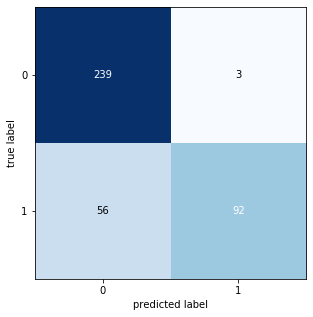

In [8]:
pred = BCNN.predict(X_test)
pred1 = np.argmax(pred,axis = 1) 
y_test1 = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test1, pred1)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

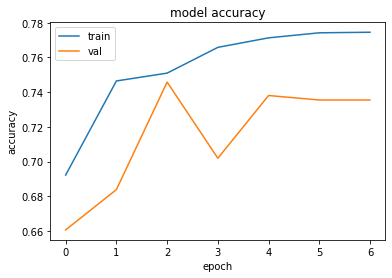

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

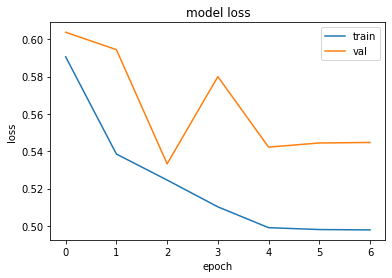

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [11]:
print(classification_report(y_test1,pred1))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       242
           1       0.97      0.62      0.76       148

    accuracy                           0.85       390
   macro avg       0.89      0.80      0.82       390
weighted avg       0.87      0.85      0.84       390

